In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
from torch import nn
from torch.nn import functional as F


import itertools
import string

import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer

from collections import Counter

from tqdm import tqdm, tqdm_notebook

from sklearn.manifold import TSNE
import plotly.express as px

In [79]:
df = pd.read_csv('//content/drive/MyDrive/df_difficult_26_01.csv')
target_names = list(set(df['doc_name'].tolist()))
label2idx = {label: idx for idx, label in enumerate(target_names)}
df['doc_name_enc']=df['doc_name'].replace(label2idx)
df

,doc_name,doc_text,text_token,text_token_filtred,text_difficult,doc_name_enc
0,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...,распоряжение президент российский федерация ус...,распоряжение президент российский федерация ус...,комитет российский федерация установить числен...,1
1,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...,распоряжение президент российский федерация пр...,распоряжение президент российский федерация пр...,российский федерация контроль оборот наркотик ...,1
2,"Указ, федеральный уровень, глава исполнительно...",указ президента российской федерации об освобо...,указ президент российский федерация освобожден...,указ президент российский федерация освобожден...,федерация контроль оборот наркотик освободить ...,0
3,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...,распоряжение президент российский федерация по...,распоряжение президент российский федерация по...,многолетний плодотворный деятельность наградит...,1
4,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...,распоряжение президент российский федерация по...,распоряжение президент российский федерация по...,молодёжь объявить благодарность андропов игорь...,1
...,...,...,...,...,...,...
22886,"Указ, региональный уровень, глава исполнительн...",губернатор орловской области у к аз о мерах по...,губернатор орловский область мера проведение к...,губернатор орловский область мера проведение к...,проживать инвалид ветеран великий отечественны...,12
22887,"Указ, региональный уровень, глава исполнительн...",ммжхжчмитжкъщ а г х м башкортостан республи...,ммжхжчмитжкъщий башкортостан республикаь респу...,ммжхжчмитжкъщий башкортостан республикаь респу...,должность заместитель премьер министр правител...,12
22888,"Указ, региональный уровень, глава исполнительн...",у к а з губернатора пермского края об отмене...,губернатор пермский край отмена ограничение ка...,губернатор пермский край отмена ограничение ка...,посёлок октябрьский соответствие закон российс...,12
22889,"Указ, региональный уровень, глава исполнительн...",у к а з губернатора пермского края г об утве...,губернатор пермский край утверждение порядок п...,губернатор пермский край утверждение порядок п...,должность пермский край отдельный должность го...,12


In [81]:
token_counts = Counter()
for row in df['text_token'].values.flatten():
    token_counts.update(row.split(" "))
token_counts_first = Counter()
for row in df['doc_text'].values.flatten():
    token_counts_first.update(row.split(" "))

In [82]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 60579
('область', 75325)
('российский', 73096)
('федерация', 72526)
('государственный', 35790)
('правительство', 33909)
...
('инострэнньха', 1)
('федерашить', 1)
('установленгш', 1)


In [83]:
print("Total unique tokens :", len(token_counts_first))
print("\n".join(map(str, token_counts_first.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts_first.most_common()[-3:])))

Total unique tokens : 97036
('', 581730)
('в', 150114)
('и', 101965)
('области', 73239)
('российской', 69619)
...
('инострэнньх', 1)
('федерашити', 1)
('установленгш', 1)


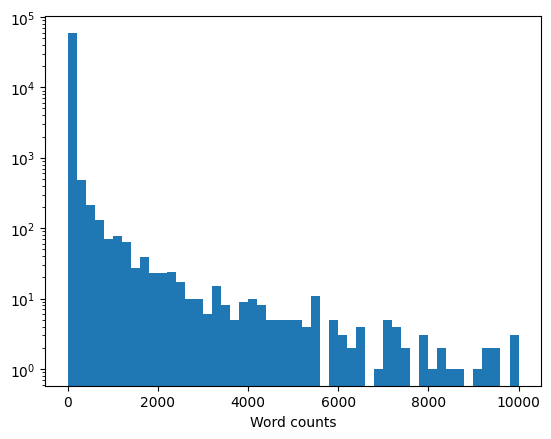

In [84]:
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts");

In [85]:
min_count = 5

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [86]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))
token_to_id = {token: idx for idx, token in enumerate(tokens)}

Vocabulary size: 11585


In [87]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float("inf"))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, : len(row_ix)] = row_ix

    return matrix


In [88]:
data_train, data_valid = train_test_split(df, test_size=0.2, random_state=42)
data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42)

In [89]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["label"] = data["doc_name_enc"].values
    batch["text"] = as_matrix(data["text_token"].values, max_len)
    if word_dropout != 0:
        batch["text"] = apply_word_dropout(batch["text"], 1.0 - word_dropout)
    return batch


def apply_word_dropout(
    matrix,
    keep_prop,
    replace_with=UNK_IX,
    pad_ix=PAD_IX,
):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [90]:
data_train.shape, data_valid.shape, data_test.shape

((14649, 6), (4579, 6), (3663, 6))

In [91]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop('label')
            yield batch, target

        if not cycle:
            break

In [92]:
n_tokens = len(tokens)

hid_size = 128

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [93]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

CUDA is available!  Training on GPU ...


device(type='cuda', index=0)

In [97]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.emb = nn.Sequential(
            nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size),
            Reorder()
        )
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=hid_size, out_channels=hid_size * 2, kernel_size=3),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=hid_size * 2, out_channels=hid_size * 2, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hid_size * 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=hid_size * 2, out_channels=hid_size * 2, kernel_size=2),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
             nn.Linear(2 * hid_size, num_classes)
        )

    def forward(self, x):
        x = self.emb(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.out(x)
        return x


num_classes=15
model = SimpleCNN(num_classes) # модель

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  betas=(0.9, 0.999))
model.to(device)

SimpleCNN(
  (emb): Sequential(
    (0): Embedding(11585, 128)
    (1): Reorder()
  )
  (conv1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(2,), stride=(1,))
    (1): ReLU()
  )
  (out): Sequential(
    (0): AdaptiveMaxPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=15, bias=True)
  )
)

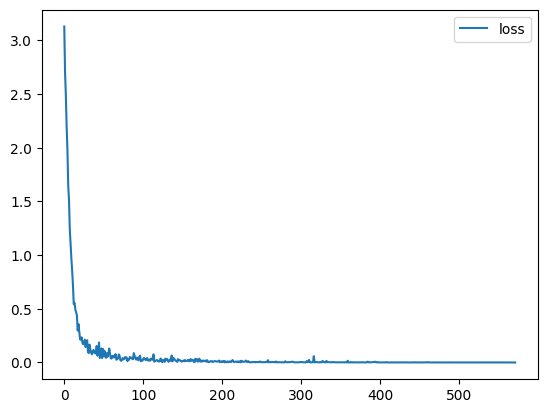

In [98]:
history = []
epochs = 10
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        optimizer.zero_grad()

        # Preprocessing the batch data and target
        features = torch.tensor(batch["text"], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)
        outp = model(features)
        #outp = outp.reshape(outp.size(0))
        loss = criterion(outp, target.long()) # лосс
        y_pred = torch.softmax(outp, dim=1).argmax(dim=1)
        acc = ((y_pred==target).detach().cpu().numpy().mean())
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [48]:
batch_size = 256
def print_metrics(model, data, batch_size=batch_size, name="", **kw):

    mean_acc = 0
    mean_loss = 0
    count = 0
    outs_vis = []
    tar_vis = []
    for batch_x, batch_y in tqdm(
        iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)
    ):

        features = torch.tensor(batch_x["text"], dtype=torch.long).to(device)
        target = torch.tensor(batch_y).to(device)

        outp = model(features)
        outs_vis.append(outp.detach().cpu())
        tar_vis.append(target.detach().cpu())
        loss = criterion(outp, target.long()) # лосс

        y_pred = torch.softmax(outp, dim=1).argmax(dim=1)

        acc = ((y_pred==target).detach().cpu().numpy().mean())

        mean_acc += acc.item()
        mean_loss += loss.item()
        count+=1

    print("Loss", mean_loss / count, "Acc", mean_acc / count)
    print(count)
    outs_vis = np.concatenate(outs_vis, axis=0)
    tar_vis = np.concatenate(tar_vis, axis=0)
    return outs_vis, tar_vis


#print_metrics(model, data_train, name="Train")
#print_metrics(model, data_test, name="Train")
outs_vis, tar_vis = print_metrics(model, data_valid, name="Val");

18it [00:00, 29.26it/s]

Loss 0.02439528952042262 Acc 0.9925660792951542
18


In [99]:
X_train, X_test, y_train, y_test = train_test_split(outs_vis, tar_vis,  test_size=0.2, random_state=42)
idx_to_label = dict()
for k, v in label2idx.items():
  idx_to_label[v] = k
y_train_enc = []
for i in y_train:
  y_train_enc.append(idx_to_label[i])
y_train_enc = np.array(y_train_enc)

In [101]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random')
tsne_results = tsne.fit_transform(X_train[:1500])
fig = px.scatter(
    tsne_results, x=0, y=1,
    color=y_train_enc[:1500], labels={'color': 'Вид НПА'}
)
fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.003s...
[t-SNE] Computed neighbors for 1500 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 5.524719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.420509
[t-SNE] KL divergence after 300 iterations: 0.823797


In [102]:
token_counts = Counter()
for row in df['text_difficult'].values.flatten():
    token_counts.update(row.split(" "))
min_count = 5

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))
token_to_id = {token: idx for idx, token in enumerate(tokens)}

Vocabulary size: 10407


In [103]:
def make_batch_dif(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["label"] = data["doc_name_enc"].values
    batch["text"] = as_matrix(data["text_difficult"].values, max_len)
    if word_dropout != 0:
        batch["text"] = apply_word_dropout(batch["text"], 1.0 - word_dropout)
    return batch


def apply_word_dropout(
    matrix,
    keep_prop,
    replace_with=UNK_IX,
    pad_ix=PAD_IX,
):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

def iterate_minibatches_dif(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch_dif(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop('label')
            yield batch, target

        if not cycle:
            break

In [104]:
num_classes=15
model = SimpleCNN(num_classes) # модель

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  betas=(0.9, 0.999))

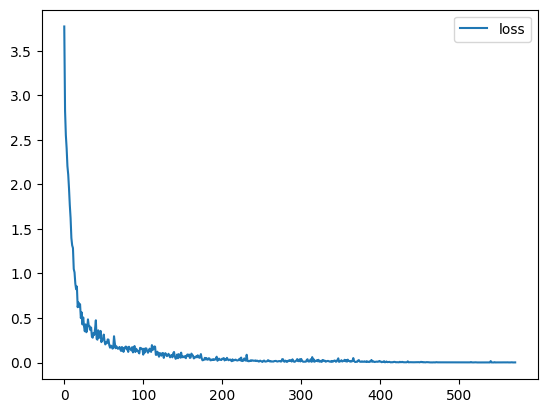

tensor([ 6,  2,  8, 12,  1, 13,  3,  6,  7,  5], device='cuda:0') tensor([ 6,  2,  8, 12,  1, 13,  3,  6,  7,  5], device='cuda:0')
tensor([ 9,  7,  3,  6, 12, 11,  9,  7,  6,  6], device='cuda:0') tensor([ 9,  7,  3,  6, 12, 11,  9,  7,  6,  6], device='cuda:0')
tensor([11,  5,  4,  1,  2, 12, 10,  5,  7,  2], device='cuda:0') tensor([11,  5,  4,  1,  2, 12, 10,  5,  7,  2], device='cuda:0')
tensor([ 8, 12, 12, 12,  6, 14,  6, 14,  9, 12], device='cuda:0') tensor([ 8, 12, 12, 12,  6, 14,  6, 14,  9, 12], device='cuda:0')
tensor([12,  6, 12,  7, 11,  7, 12,  6, 11, 13], device='cuda:0') tensor([12,  6, 12,  7, 11,  7, 12,  6, 11, 13], device='cuda:0')
tensor([ 3,  7,  7, 13,  8,  2, 12,  0, 12,  1], device='cuda:0') tensor([ 3,  7,  7, 13,  8,  2, 12,  0, 12,  1], device='cuda:0')
tensor([ 2, 10,  2, 10,  5,  5,  3,  1,  9, 11], device='cuda:0') tensor([ 2, 10,  2, 10,  5,  5,  3,  1,  9, 11], device='cuda:0')
tensor([10,  2,  4, 13,  6,  0,  5,  6,  9,  9], device='cuda:0') tensor([10

In [105]:
history = []
epochs = 10
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches_dif(data_train)):
        optimizer.zero_grad()

        # Preprocessing the batch data and target
        features = torch.tensor(batch["text"], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)

        outp = model(features)
        #outp = outp.reshape(outp.size(0))

        loss = criterion(outp, target.long()) # лосс

        y_pred = torch.softmax(outp, dim=1).argmax(dim=1)
        print(y_pred[:10], target[:10])

        acc = ((y_pred==target).detach().cpu().numpy().mean())


        loss.backward()
        optimizer.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [106]:
batch_size = 256
def print_metrics_dif(model, data, batch_size=batch_size, name="", **kw):

    mean_acc = 0
    mean_loss = 0
    count = 0
    outs_vis = []
    tar_vis = []
    for batch_x, batch_y in tqdm(
        iterate_minibatches_dif(data, batch_size=batch_size, shuffle=False, **kw)
    ):

        features = torch.tensor(batch_x["text"], dtype=torch.long).to(device)
        target = torch.tensor(batch_y).to(device)

        outp = model(features)
        outs_vis.append(outp.detach().cpu())
        tar_vis.append(target.detach().cpu())
        loss = criterion(outp, target.long()) # лосс

        y_pred = torch.softmax(outp, dim=1).argmax(dim=1)

        acc = ((y_pred==target).detach().cpu().numpy().mean())

        mean_acc += acc.item()
        mean_loss += loss.item()
        count+=1

    print("Loss", mean_loss / count, "Acc", mean_acc / count)
    print(count)
    outs_vis = np.concatenate(outs_vis, axis=0)
    tar_vis = np.concatenate(tar_vis, axis=0)
    return outs_vis, tar_vis


#print_metrics(model, data_train, name="Train")
#print_metrics(model, data_test, name="Train")
outs_vis, tar_vis = print_metrics_dif(model, data_valid, name="Val");

18it [00:00, 29.63it/s]

Loss 0.1183779982642995 Acc 0.9659794878854626
18


In [107]:
X_train, X_test, y_train, y_test = train_test_split(outs_vis, tar_vis,  test_size=0.2, random_state=42)
idx_to_label = dict()
for k, v in label2idx.items():
  idx_to_label[v] = k
y_train_enc = []
for i in y_train:
  y_train_enc.append(idx_to_label[i])
y_train_enc = np.array(y_train_enc)

In [108]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random')
tsne_results = tsne.fit_transform(X_train[:1500])
fig = px.scatter(
    tsne_results, x=0, y=1,
    color=y_train_enc[:1500], labels={'color': 'Вид НПА'}
)
fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.005s...
[t-SNE] Computed neighbors for 1500 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 5.478867
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.310638
[t-SNE] KL divergence after 300 iterations: 0.841334
